# Ensemble Learning: Bagging and Stacking

## Name: Joseph Willemsz

## Date: April 18, 2022

Dataset: https://www.kaggle.com/datasets/riinuanslan/sleep-data-from-fitbit-tracker

Goal: 

- Can we predict Sleep Score (posted by the FitBit app) using the other metrics in the dataset? In other words, is there a formula here that the FitBit app uses to compute Sleep Score that we can reverse-engineer?
Two constraints for this assignment:

1. Your modeling efforts must involve bagging and stacking in some way. Otherwise, you may try whatever you like.

2. You are allowed, even encouraged, to compute and/or gather additional features to use as explanatory variables in your model. For example, you might create a variable for the time they went to sleep (as a measure of how "early" they went to bed, or not). There are multiple datasets and you should use all of them, which means you may use the corresponding month for the dataset as a variable as well (or anything related to it).

# Table of Contents

- [Data Import and Cleaning](#dataimport)
- [Bagging](#bagging)
- [Random Forest](#randomforest)
- [Stacking](#stacking)
- [Conclusion](#conclusion)



---

# Data Import and Cleaning <a class="anchor" id="dataimport"></a>

In [159]:
# import the monthly fitbit datasets
nov_data = pd.read_csv("Data/November Sleep data - Sheet1.csv").dropna()
dec_data = pd.read_csv("Data/December Sleep data - Sheet1.csv").dropna()
jan_data = pd.read_csv("Data/January Sleep data - Sheet1.csv").dropna()
feb_data = pd.read_csv("Data/February Sleep data - Sheet1.csv").dropna()

In [160]:
# create new column to specify month
nov_data["month"] = "November"
dec_data["month"] = "December"
jan_data["month"] = "January"
feb_data["month"] = "February"

In [161]:
# rename variables in each df
nov_data.rename(columns = {"NOVEMBER":"day_of_week",
                           "DATE":"date",
                           "SLEEP SCORE":"sleep_score",
                           "HOURS OF SLEEP":"hours_of_sleep",
                           "REM SLEEP":"rem_sleep",
                           "DEEP SLEEP":"deep_sleep",
                           "HEART RATE BELOW RESTING":"hr_below_resting",
                           "SLEEP TIME":"sleep_time"
                          }, inplace = True)

dec_data.rename(columns = {"DECEMBER":"day_of_week",
                           "DATE":"date",
                           "SLEEP SCORE":"sleep_score",
                           "HOURS OF SLEEP":"hours_of_sleep",
                           "REM SLEEP":"rem_sleep",
                           "DEEP SLEEP":"deep_sleep",
                           "HEART RATE BELOW RESTING":"hr_below_resting",
                           "SLEEP TIME":"sleep_time"
                          }, inplace = True)

jan_data.rename(columns = {"JANUARY":"day_of_week",
                           "DATE":"date",
                           "SLEEP SCORE":"sleep_score",
                           "HOURS OF SLEEP":"hours_of_sleep",
                           "REM SLEEP":"rem_sleep",
                           "DEEP SLEEP":"deep_sleep",
                           "HEART RATE UNDER RESTING":"hr_below_resting",
                           "SLEEP TIME":"sleep_time"
                          }, inplace = True)

feb_data.rename(columns = {"FEBEUARY":"day_of_week",
                           "DATE":"date",
                           "SLEEP SQORE":"sleep_score",
                           "HOURS OF SLEEP":"hours_of_sleep",
                           "REM SLEEP":"rem_sleep",
                           "DEEP SLEEP":"deep_sleep",
                           "HEART RATE BELOW RESTING":"hr_below_resting",
                           "SLEEP TIME":"sleep_time"
                          }, inplace = True)

In [162]:
# combine all data frames into one
fitbit_data = pd.concat([nov_data, dec_data, jan_data, feb_data], 
          ignore_index = True, 
          sort = False)

In [163]:
# move month variable to the front of data frame
column_to_move = fitbit_data.pop("month")

# insert column with insert(location, column_name, column_value)
fitbit_data.insert(0, "month", column_to_move)

In [164]:
# convert sleep/resting variables to float data types
fitbit_data.rem_sleep = fitbit_data.rem_sleep.str.replace("%", "").astype(float) / 100
fitbit_data.deep_sleep = fitbit_data.deep_sleep.str.replace("%", "").astype(float) / 100
fitbit_data.hr_below_resting = fitbit_data.hr_below_resting.str.replace("%", "").astype(float) / 100

In [165]:
import time

# function the turns time format to hours in decimals 8:06:00 -> 8.1
def convert_hrs(time_string):
    date_var = time.strptime(time_string, '%I:%M:%S')

    return date_var.tm_hour + date_var.tm_min/60

convert_hrs('10:07:00')

10.116666666666667

In [166]:
# convert hours_of_sleep variable to hours in decimal float
fitbit_data["hours_of_sleep"] = fitbit_data["hours_of_sleep"].apply(convert_hrs)

In [167]:
# seperates the sleep time into 2 seperate variables time1 and time2
time1 = []
time2 = []
for row in range(len(fitbit_data)):
    time1.append(fitbit_data["sleep_time"].str.split(pat=" - ")[row][0])
    time2.append(fitbit_data["sleep_time"].str.split(pat=" - ")[row][1])
    
time1 = pd.DataFrame(time1, columns=["time1"])
time2 = pd.DataFrame(time2, columns=["time2"])

In [168]:
# this function converts am to AM and changes pm to PM
def format_time(string):
    if "am" in string:
        time = string.replace("am", "AM")
        return time
    else:
        time = string.replace("pm", "PM")
        return time
    
print(format_time("12:00pm"))
print(format_time("12:00am"))
print(format_time("07:13am"))
print(format_time("07:13pm"))

12:00PM
12:00AM
07:13AM
07:13PM


In [169]:
bed_time = []
wake_time = []
for i in range(len(time1)):
    bed_time.append(format_time(time1.time1[i]))
    wake_time.append(format_time(time2.time2[i]))
    
bed_time = pd.DataFrame(bed_time, columns=["bed_time"])
wake_time = pd.DataFrame(wake_time, columns=["wake_time"])

In [170]:
# combine date and bed/wake time to make datetime variable
bed_time = (fitbit_data["date"] + " " + bed_time["bed_time"])
wake_time = (fitbit_data["date"] + " " + wake_time["wake_time"])

In [171]:
import datetime

# converts datetime string to datetime datatype
def to_datetime(datetime_string):
    #set the date and time format
    date_format = "%m/%d/%Y %I:%M%p"
    #date_format = "%I:%M%p"

    return datetime.datetime.strptime(datetime_string, date_format)

print(to_datetime('07/13/1997 07:13AM'))

1997-07-13 07:13:00


In [172]:
# apply to_datetime() to bed_time and wake_time variable
bed_time = bed_time.apply(to_datetime)
wake_time = wake_time.apply(to_datetime)

In [173]:
from datetime import datetime
from datetime import timedelta

# adding a day to the wake-up time since the person wakes up the following day
wake_time = wake_time + timedelta(days=1)

In [174]:
# sleep duration time in minutes
sleep_time_minutes = (wake_time - bed_time) / np.timedelta64(1, 'm')

In [181]:
fitbit_data["bed_time"] = bed_time
fitbit_data["wake_time"] = wake_time
fitbit_data["sleep_time_minutes"] = sleep_time_minutes

fitbit_data

,month,day_of_week,date,sleep_score,hours_of_sleep,rem_sleep,deep_sleep,hr_below_resting,sleep_time,sleep_time_minutes,bed_time,wake_time
0,November,Monday,11/1/2021,88.0,8.100000,0.20,0.13,0.84,10:41pm - 7:54am,553.0,2021-11-01 22:41:00,2021-11-02 07:54:00
1,November,Tuesday,11/2/2021,83.0,7.950000,0.12,0.18,0.90,10:40pm - 7:55am,555.0,2021-11-02 22:40:00,2021-11-03 07:55:00
2,November,Wednesday,11/3/2021,81.0,7.100000,0.13,0.22,0.93,11:03pm - 7:16am,493.0,2021-11-03 23:03:00,2021-11-04 07:16:00
3,November,Thursday,11/4/2021,86.0,7.066667,0.19,0.17,0.97,10:55pm - 6:56am,481.0,2021-11-04 22:55:00,2021-11-05 06:56:00
4,November,Friday,11/5/2021,81.0,9.400000,0.17,0.15,0.66,10:14pm - 9:01am,647.0,2021-11-05 22:14:00,2021-11-06 09:01:00
...,...,...,...,...,...,...,...,...,...,...,...,...
115,February,Thursday,2/24/2022,84.0,7.300000,0.19,0.19,0.96,10:23pm - 6:43am,500.0,2022-02-24 22:23:00,2022-02-25 06:43:00
116,February,Friday,2/25/2022,90.0,7.766667,0.20,0.21,0.98,10:28pm - 7:15am,527.0,2022-02-25 22:28:00,2022-02-26 07:15:00
117,February,Saturday,2/26/2022,82.0,8.033333,0.16,0.16,0.57,11:05pm - 8:10am,545.0,2022-02-26 23:05:00,2022-02-27 08:10:00
118,February,Sunday,2/27/2022,85.0,8.900000,0.18,0.17,0.81,9:59pm - 8:11am,612.0,2022-02-27 21:59:00,2022-02-28 08:11:00


In [182]:
# predictor dataset and target variable dataset
X = fitbit_data.drop(['sleep_score', 'sleep_time', 'date', 'bed_time', 'wake_time'], axis='columns')
y = fitbit_data["sleep_score"]

In [183]:
# create dummy variables for categorical variables
X = pd.get_dummies(X)
X

,hours_of_sleep,rem_sleep,deep_sleep,hr_below_resting,sleep_time_minutes,month_December,month_February,month_January,month_November,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,8.100000,0.20,0.13,0.84,553.0,0,0,0,1,0,1,0,0,0,0,0
1,7.950000,0.12,0.18,0.90,555.0,0,0,0,1,0,0,0,0,0,1,0
2,7.100000,0.13,0.22,0.93,493.0,0,0,0,1,0,0,0,0,0,0,1
3,7.066667,0.19,0.17,0.97,481.0,0,0,0,1,0,0,0,0,1,0,0
4,9.400000,0.17,0.15,0.66,647.0,0,0,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,7.300000,0.19,0.19,0.96,500.0,0,1,0,0,0,0,0,0,1,0,0
116,7.766667,0.20,0.21,0.98,527.0,0,1,0,0,1,0,0,0,0,0,0
117,8.033333,0.16,0.16,0.57,545.0,0,1,0,0,0,0,1,0,0,0,0
118,8.900000,0.18,0.17,0.81,612.0,0,1,0,0,0,0,0,1,0,0,0


---

# Bagging <a class="anchor" id="bagging"></a>

## Explore Number of Trees

In [179]:
# explore bagging ensemble number of trees effect on performance
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import BaggingRegressor
from matplotlib import pyplot

# get a list of models to evaluate
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [10, 50, 100, 200, 500, 1000]
    for n in n_trees:
        models[str(n)] = BaggingRegressor(n_estimators=n)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packag

>10 -1.584 (0.354)
>50 -1.556 (0.372)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>100 -1.510 (0.322)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>200 -1.524 (0.349)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>500 -1.515 (0.333)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>1000 -1.508 (0.332)


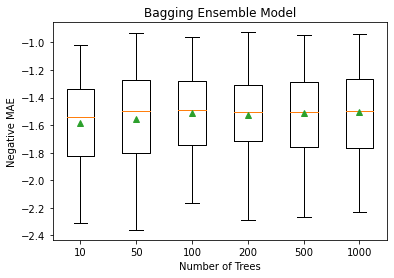

In [180]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xlabel("Number of Trees")
pyplot.ylabel("Negative MAE")
pyplot.title("Bagging Ensemble Model")
pyplot.show()

## Explore Number of Samples

In [30]:
# explore bagging ensemble number of samples effect on performance
from numpy import mean
from numpy import std
from numpy import arange
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import BaggingClassifier
from matplotlib import pyplot

# get a list of models to evaluate
def get_models():
    models = dict()
    # explore ratios from 10% to 100% in 10% increments
    for i in arange(0.1, 1.1, 0.1):
        key = '%.1f' % i
        models[key] = BaggingRegressor(max_samples=i, n_estimators=1000)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>0.1 -2.358 (0.663)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>0.2 -1.915 (0.568)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>0.3 -1.724 (0.508)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>0.4 -1.638 (0.467)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>0.5 -1.578 (0.418)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>0.6 -1.561 (0.393)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>0.7 -1.531 (0.370)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>0.8 -1.521 (0.359)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>0.9 -1.509 (0.346)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>1.0 -1.501 (0.326)


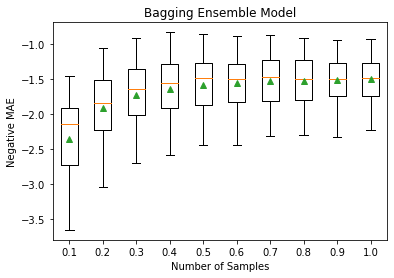

In [31]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xlabel("Number of Samples")
pyplot.ylabel("Negative MAE")
pyplot.title("Bagging Ensemble Model")
pyplot.show()

After analyzing various hyperparameters for our bagging ensemble model by identifying the lowest the mean absolute error (MAE) value we determined:
- Optimal number of trees $\rightarrow$ **1000**
- Optimal number of samples $\rightarrow$ **1.0**

---

# Random Forest <a class="anchor" id="randomforest"></a>

## Explore Number of Samples

In [39]:
# explore random forest bootstrap sample size on performance
from numpy import mean
from numpy import std
from numpy import arange
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
 
# get a list of models to evaluate
def get_models():
    models = dict()
    # explore ratios from 10% to 100% in 10% increments
    for i in arange(0.1, 1.1, 0.1):
        key = '%.1f' % i
        # set max_samples=None to use 100%
        if i == 1.0:
            i = None
        models[key] = RandomForestRegressor(max_samples=i)
    return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return scores
 
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>0.1 -2.303 (0.653)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>0.2 -1.920 (0.580)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>0.3 -1.757 (0.536)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>0.4 -1.635 (0.465)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>0.5 -1.579 (0.403)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>0.6 -1.562 (0.401)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>0.7 -1.547 (0.367)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>0.8 -1.528 (0.345)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>0.9 -1.531 (0.335)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>1.0 -1.519 (0.316)


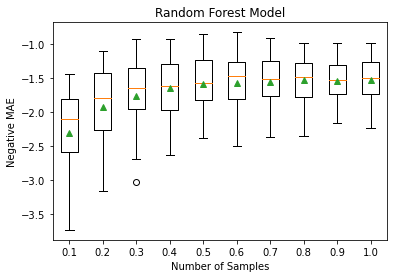

In [40]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xlabel("Number of Samples")
pyplot.ylabel("Negative MAE")
pyplot.title("Random Forest Model")
pyplot.show()

## Explore Number of Trees

In [43]:
# explore random forest number of trees effect on performance
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

# get a list of models to evaluate
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [10, 50, 100, 200, 500, 1000]
    for n in n_trees:
        models[str(n)] = RandomForestRegressor(n_estimators=n)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packag

>10 -1.566 (0.365)
>50 -1.530 (0.352)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>100 -1.517 (0.349)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>200 -1.513 (0.345)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>500 -1.507 (0.317)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>1000 -1.499 (0.326)


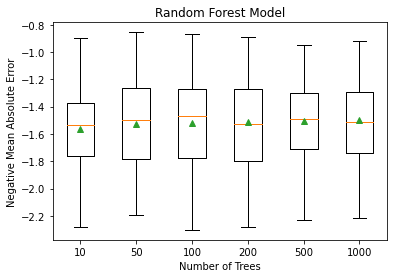

In [45]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xlabel("Number of Trees")
pyplot.ylabel("Negative Mean Absolute Error")
pyplot.title("Random Forest Model")
pyplot.show()

## Explore Number of Features

In [50]:
# explore random forest number of features effect on performance
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
 
# get a list of models to evaluate
def get_models():
    models = dict()
    # explore number of features from 1 to 16
    for i in range(1,17):
        models[str(i)] = RandomForestRegressor(max_features=i, n_estimators=1000)
    return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return scores
 
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>1 -2.527 (0.661)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>2 -2.242 (0.602)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>3 -1.991 (0.558)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>4 -1.849 (0.502)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>5 -1.736 (0.462)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>6 -1.665 (0.418)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>7 -1.605 (0.406)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>8 -1.574 (0.380)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>9 -1.547 (0.364)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>10 -1.521 (0.360)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>11 -1.511 (0.344)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>12 -1.511 (0.338)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>13 -1.510 (0.334)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>14 -1.497 (0.325)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>15 -1.499 (0.327)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>16 -1.503 (0.326)


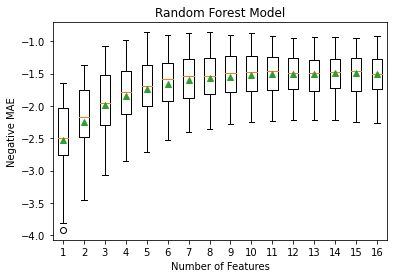

In [51]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xlabel("Number of Features")
pyplot.ylabel("Negative MAE")
pyplot.title("Random Forest Model")
pyplot.show()

## Explore Tree Depth

In [52]:
# explore random forest tree depth effect on performance
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot

 
# get a list of models to evaluate
def get_models():
    models = dict()
    # consider tree depths from 1 to 7 and None=full
    depths = [i for i in range(1,8)] + [None]
    for n in depths:
        models[str(n)] = RandomForestRegressor(max_depth=n, max_features=14, n_estimators=1000)
    return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return scores
 
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>1 -2.782 (0.519)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>2 -2.179 (0.471)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>3 -1.789 (0.392)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>4 -1.598 (0.361)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>5 -1.535 (0.350)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>6 -1.505 (0.332)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>7 -1.512 (0.338)


C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\joewi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


>None -1.502 (0.335)


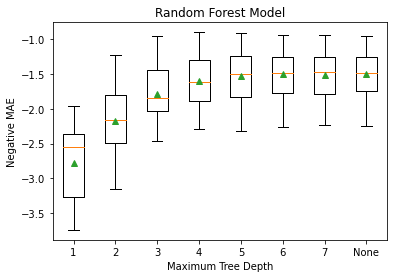

In [53]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xlabel("Maximum Tree Depth")
pyplot.ylabel("Negative MAE")
pyplot.title("Random Forest Model")
pyplot.show()

After analyzing various hyperparameters for our random forest model by identifying the lowest the mean absolute error (MAE) value we determined:
- Optimal number of samples $\rightarrow$ **1.0**
- Optimal number of trees $\rightarrow$ **1000**
- Optimal number of features $\rightarrow$ **14**
- Optimal tree depth $\rightarrow$ **None**

---

# Stacking <a class="anchor" id="stacking"></a>

Base models:
- **Linear regression**
- **k-nearest neighbors**
- **Decision trees**
- **Support vector machines**
- **Bagging**
- **Random forest**

>lr -1.648 (0.377)
>knn -3.423 (0.901)
>cart -1.975 (0.477)
>svm -3.443 (0.812)
>bag -1.503 (0.391)
>rf -1.504 (0.381)
>stacking -1.390 (0.320)


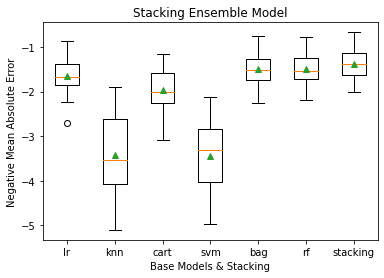

In [92]:
# compare ensemble to each standalone models for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from matplotlib import pyplot

# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('lr', LinearRegression()))
    level0.append(('knn', KNeighborsRegressor()))
    level0.append(('cart', DecisionTreeRegressor()))
    level0.append(('svm', SVR()))
    level0.append(('bag', BaggingRegressor(n_estimators=1000)))
    level0.append(('rf', RandomForestRegressor(n_estimators=1000)))
    # define meta learner model
    level1 = LinearRegression()
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model

# get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LinearRegression()
    models['knn'] = KNeighborsRegressor()
    models['cart'] = DecisionTreeRegressor()
    models['svm'] = SVR()
    models['bag'] = BaggingRegressor(n_estimators=1000)
    models['rf'] = RandomForestRegressor(n_estimators=1000)
    models['stacking'] = get_stacking()
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xlabel("Base Models & Stacking")
pyplot.ylabel("Negative Mean Absolute Error")
pyplot.title("Stacking Ensemble Model")
pyplot.show()

>lr -1.648 (0.377)
>cart -1.953 (0.546)
>bag -1.500 (0.384)
>rf -1.504 (0.381)
>stacking -1.346 (0.292)


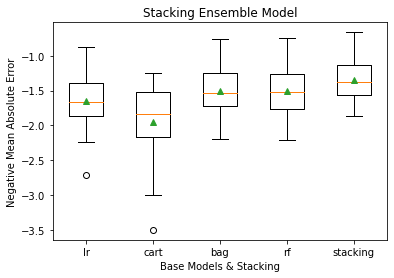

In [93]:
# compare ensemble to each standalone models for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from matplotlib import pyplot

# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('lr', LinearRegression()))
    #level0.append(('knn', KNeighborsRegressor()))
    level0.append(('cart', DecisionTreeRegressor()))
    #level0.append(('svm', SVR()))
    level0.append(('bag', BaggingRegressor(n_estimators=1000)))
    level0.append(('rf', RandomForestRegressor(n_estimators=1000)))
    # define meta learner model
    level1 = LinearRegression()
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model

# get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LinearRegression()
    #models['knn'] = KNeighborsRegressor()
    models['cart'] = DecisionTreeRegressor()
    #models['svm'] = SVR()
    models['bag'] = BaggingRegressor(n_estimators=1000)
    models['rf'] = RandomForestRegressor(n_estimators=1000)
    models['stacking'] = get_stacking()
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xlabel("Base Models & Stacking")
pyplot.ylabel("Negative Mean Absolute Error")
pyplot.title("Stacking Ensemble Model")
pyplot.show()

>lr -1.648 (0.377)
>bag -1.504 (0.372)
>rf -1.492 (0.384)
>stacking -1.337 (0.274)


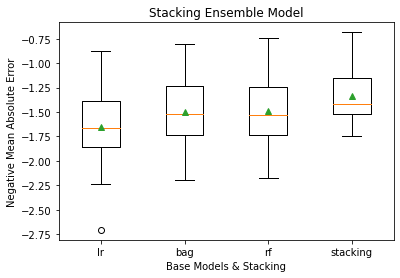

In [96]:
# compare ensemble to each standalone models for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from matplotlib import pyplot

# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('lr', LinearRegression()))
    #level0.append(('knn', KNeighborsRegressor()))
    #level0.append(('cart', DecisionTreeRegressor()))
    #level0.append(('svm', SVR()))
    level0.append(('bag', BaggingRegressor(n_estimators=1000)))
    level0.append(('rf', RandomForestRegressor(n_estimators=1000)))
    # define meta learner model
    level1 = LinearRegression()
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model

# get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LinearRegression()
    #models['knn'] = KNeighborsRegressor()
    #models['cart'] = DecisionTreeRegressor()
    #models['svm'] = SVR()
    models['bag'] = BaggingRegressor(n_estimators=1000)
    models['rf'] = RandomForestRegressor(n_estimators=1000)
    models['stacking'] = get_stacking()
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xlabel("Base Models & Stacking")
pyplot.ylabel("Negative Mean Absolute Error")
pyplot.title("Stacking Ensemble Model")
pyplot.show()

The following are the optimal base models for our stacking ensemble model. We determined this from analyzing various combinations of stacking base models and identifying the combination with the smallest mean absolute error value:
- **Linear regression**
- **Bagging**
- **Random forest**

---

# Conclusion <a class="anchor" id="conclusion"></a>

## Optimal Bagging Ensemble Model

In [56]:
# define the model
model = BaggingRegressor(n_estimators=1000, max_samples=1.0)

# evaluate the model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('MAE = %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE = -1.499 (0.382)


## Optimal Random Forest Model

In [62]:
# define the model
model = RandomForestRegressor(n_estimators=1000, max_features=14, max_depth=None)

# evaluate the model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: -1.495 (0.390)


## Optimal Stacking Ensemble Model

In [97]:
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('lr', LinearRegression()))
    #level0.append(('knn', KNeighborsRegressor()))
    #level0.append(('cart', DecisionTreeRegressor()))
    #level0.append(('svm', SVR()))
    level0.append(('bag', BaggingRegressor(n_estimators=1000)))
    level0.append(('rf', RandomForestRegressor(n_estimators=1000)))
    # define meta learner model
    level1 = LinearRegression()
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model

# get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LinearRegression()
    #models['knn'] = KNeighborsRegressor()
    #models['cart'] = DecisionTreeRegressor()
    #models['svm'] = SVR()
    models['bag'] = BaggingRegressor(n_estimators=1000)
    models['rf'] = RandomForestRegressor(n_estimators=1000)
    models['stacking'] = get_stacking()
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>lr -1.648 (0.377)
>bag -1.502 (0.387)
>rf -1.498 (0.385)
>stacking -1.343 (0.297)


Based on the mean absolute error (MAE) values from the optimal models, we can see that the **stacking** model does the best in predicting fitbit sleep scores with the following base models:
- Linear regression
- Bagging
- Random forest

This model has the lowest MAE = -1.343. The random forest model performs the next best (MAE = -1.495), closely followed by the bagging ensemble model (MAE = -1.499)